In [935]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import json
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm

from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**CS-401 Applied Data Analysis**  
**Project Milestone 3** 

**Group ID:** TheSuricates  

# **Budget Battles:** Maximizing Returns in Filmmaking Odyssey

The film industry is a growing industry of $42.2 billion in 2019 in theatrical box office alone. Including home entertainment, it reached $139 billion in 2018. However, a big budget doesn't always mean an important return on investment (ROI). In 2002, the film The Adventures of Pluto Nash cost $100 million to produce but generated only $7 million. This example shows that a high budget is not always synonymous with a profitable return. On the contrary, the movie Paranormal activity had a budget of $200K and a box office of over $190 million. Is it easier to multiply the revenue from a high or low budget movie?

That's what two producer friends with very different wallets ask themselves over a drink. "I bet I can multiply my investment a lot more than you can with my big-budget film!". "We'll see about that!" replies the other with modesty. Let's follow these two friends on their exciting adventure and see what we can do to help! This story will take us to the core of the movie industry by exploring interesting parameters of the TMDb dataset.

We will determine which movie features have a significant impact on the ROI, and then find the best strategy to maximize it, for both high and low budget producers. Which producer will win the bet?

### Import TMDB dataset

In [936]:
PATH = './data/'

character = pd.read_csv(PATH + 'tmdb_person.csv')
movie = pd.read_csv(PATH + 'tmdb_movies.csv')

# Cleaning and preparing data

## Cleaning

We will first remove all the *missing values* (Nans or 0) in the features we will use.

In [937]:
# Remove rows in the movie dataframe containing NaNs on features we will use
cleaned_movie = movie.copy()
cleaned_movie.dropna(subset=['budget', 'revenue', 'release_date', 'runtime',
                              'original_language', 'genres', 'production_countries', 'spoken_languages', 'title'], inplace=True)


# Remove rows in the character dataframe without actor names
cleaned_character = character.copy()
cleaned_character.dropna(subset=['name','birthday', 'gender', 'popularity'], inplace=True)

In [938]:
# Remove rows in the movie dataframe where the revenue or budget are null
cleaned_movie = cleaned_movie[(cleaned_movie['budget'] != 0) & (cleaned_movie['revenue'] != 0)]

# Remove the duplicates
cleaned_movie.drop_duplicates(subset='id', inplace=True)


In [939]:
#restructuring the character dataframe 
cleaned_character['movie_id'] = cleaned_character['played_in_movie_id'].apply(json.loads) #type cast string to list
cleaned_character = cleaned_character.explode('movie_id') #now every row is a different movie id
cleaned_character = cleaned_character.drop('played_in_movie_id', axis=1)

## Preparing movie features

For our analysis, we will need to have the age of the actors when they appear in the movie. 

In [940]:
# add the release date to character dataframe
cleaned_movie = cleaned_movie.rename(columns={'id': 'movie_id'})
cleaned_character = cleaned_character.merge(cleaned_movie[['movie_id', 'release_date']],left_on="movie_id",right_on="movie_id",how ="left")
cleaned_character = cleaned_character.rename(columns={'id': 'actor_id'})

# cleaning
cleaned_character.dropna(subset=['release_date'], inplace=True)
cleaned_character.drop_duplicates(subset=['actor_id', 'movie_id'],inplace=True)

# calculate the age of actors in the movie
cleaned_character['age'] = cleaned_character.release_date.apply(convert_to_datetime).dt.year - cleaned_character.birthday.apply(convert_to_datetime).dt.year


### Movie features dataframe

Let's create our own dataframe with some features which could have an effect on the `multiplier` of the money earned relative to the money invested in the film.

First we will use features which already exist in the movie metadata : the `runtime`, movie `original language`, `genre`, `production countries` and `spoken languages`. We will also need to keep the `movie id`, the `title` of the movie, the `release date`, the `budget` and the `revenue` for our analysis.

In [941]:
# Create a new dataframe using movie information
movie_features = cleaned_movie[['movie_id', 'title', 'budget', 'revenue', 'release_date', 'runtime',
                              'original_language', 'genres', 'production_countries', 'spoken_languages']].copy()
movie_features.head()

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages
0,901362.0,Trolls Band Together,95000000.0,107900000.0,2023-10-12,92.0,en,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'..."
1,670292.0,The Creator,80000000.0,104000000.0,2023-09-27,134.0,en,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...","[{'english_name': 'English', 'iso_639_1': 'en'..."
2,872585.0,Oppenheimer,100000000.0,950200000.0,2023-07-19,181.0,en,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...","[{'english_name': 'Dutch', 'iso_639_1': 'nl', ..."
3,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'..."
4,872906.0,Jawan,36150000.0,136698671.0,2023-09-07,169.0,hi,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'iso_3166_1': 'IN', 'name': 'India'}]","[{'english_name': 'Hindi', 'iso_639_1': 'hi', ..."


In [942]:
# Keep the genres,productions_countries and spoken_languages as a list of strings
movie_features['genres'] = movie_features['genres'].str.replace("'", "\"")
movie_features['genres'] = movie_features['genres'].apply(lambda x: [entry['name'] for entry in json.loads(x)])

movie_features['production_countries'] = movie_features['production_countries'].str.replace("'", "\"")
movie_features['production_countries'] = movie_features['production_countries'].apply(lambda x: [entry['name'] for entry in json.loads(x)])

movie_features['spoken_languages'] = movie_features['spoken_languages'].str.replace("'", "\"")
movie_features['spoken_languages'] = movie_features['spoken_languages'].apply(lambda x: [entry['name'] for entry in json.loads(x)])

From those features, we can also calculate the `title word count`, the `spoken languages count`, and the `release quarter` of the movie.

In [943]:
#count the number of words in title
movie_features['title_word_count'] = movie_features['title'].apply(lambda x: len(str(x).split(" ")))
#count number languages in spoken_languages
movie_features['spoken_languages_count'] = movie_features['spoken_languages'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))

#find period of the year (spring,automn..) when movie was released
movie_features['release_date'] = pd.to_datetime(movie_features['release_date'])
# movie_features['release_month'] = movie_features['release_date'].dt.month
movie_features['release_quarter'] = movie_features['release_date'].dt.quarter

We will also create new features from the character metadata : 
- the `number of characters` per movie
- the `average experience` of actors : the average upon all actors of the number of movies they appear in (before the movie)
- the `min experience` and `max experience`
- the `male ratio` of actors
- the `ratio of young actors` (below 18 years old)
- the `ratio of old actors` (above 60 years old)
- the `average age of actors`, the `min age` and `max age`
- the `average popularity`, `min popularity` and `max popularity`


In [944]:
# Total number of characters, number by age category and by gender
counts = cleaned_character.groupby('movie_id').agg(
    number_characters=('actor_id', 'size'),
    below18=('age', lambda x: (x < 18).sum()),
    above60=('age', lambda x: (x > 60).sum()),
    male_ratio=('gender', lambda x: (x == 2).sum()),
    average_age=('age', 'mean'),
    max_age=('age', 'max'),
    min_age=('age', 'min'),
    average_popularity=('popularity', 'mean'),
    max_popularity=('popularity', 'max'),
    min_popularity=('popularity', 'min')
).reset_index()

# We change the number of characters by age/gender by the ratio above total number of characters
counts['below18'] = counts['below18'] / counts['number_characters']
counts['above60'] = counts['above60'] / counts['number_characters']
counts['male_ratio'] = counts['male_ratio'] / counts['number_characters']

# Add the new columns to our movie_features dataframe
movie_features = pd.merge(movie_features, counts, left_on='movie_id', right_on='movie_id', how='left')

In [945]:
# Actors' experience

# Sort by the date of release (dor) within each actor group
sorted_character = cleaned_character.sort_values(['actor_id', 'release_date'])

# Calculate cumulative count of movies for each actor up to the current movie
sorted_character['cumulative_movie_count'] = sorted_character.groupby('actor_id').cumcount()

# Group by movie (wiki_id) and calculate the mean upon all actors of cumulative movie counts for each movie
means = sorted_character.groupby('movie_id')['cumulative_movie_count'].mean().reset_index()
means.columns = ['movie_id', 'average_actor_exp']
min = sorted_character.groupby('movie_id')['cumulative_movie_count'].min().reset_index()
min.columns = ['movie_id', 'min_actor_exp']
max = sorted_character.groupby('movie_id')['cumulative_movie_count'].max().reset_index()
max.columns = ['movie_id', 'max_actor_exp']
experience_per_movie = pd.merge(means, min, on='movie_id', how='left')
experience_per_movie = pd.merge(experience_per_movie, max, on='movie_id', how='left')

# Merge with the 'movie_features' dataframe
movie_features = pd.merge(movie_features, experience_per_movie, on='movie_id', how='left')
movie_features.head()

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages,...,male_ratio,average_age,max_age,min_age,average_popularity,max_popularity,min_popularity,average_actor_exp,min_actor_exp,max_actor_exp
0,901362.0,Trolls Band Together,95000000.0,107900000.0,2023-10-12,92.0,en,"[Animation, Family, Music, Fantasy, Comedy]",[United States of America],[English],...,0.666667,43.000000,63.0,26.0,18.170133,41.405,11.097,7.133333,0.0,19.0
1,670292.0,The Creator,80000000.0,104000000.0,2023-09-27,134.0,en,"[Science Fiction, Action, Thriller]","[Canada, United States of America]","[English, 日本語, ภาษาไทย, Tiếng Việt]",...,0.600000,44.400000,64.0,9.0,42.415400,200.246,12.063,6.800000,0.0,25.0
2,872585.0,Oppenheimer,100000000.0,950200000.0,2023-07-19,181.0,en,"[Drama, History]","[United Kingdom, United States of America]","[Nederlands, English]",...,0.878049,45.975610,82.0,26.0,31.225268,126.861,10.031,8.585366,0.0,43.0
3,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"[Horror, Mystery]",[United States of America],[English],...,0.600000,36.800000,57.0,12.0,56.929800,147.890,16.509,5.600000,0.0,14.0
4,872906.0,Jawan,36150000.0,136698671.0,2023-09-07,169.0,hi,"[Action, Adventure, Thriller]",[India],[हिन्दी],...,0.571429,41.571429,58.0,31.0,17.866000,25.979,11.017,3.000000,0.0,13.0


In [946]:
# Remove nans
movie_features.dropna(inplace=True)

## Separate low and high budget movies

### Removing outliers

In [947]:
# Create a new column corresponding to the ratio between the revenue and budget of the movie
movie_features['multiplier'] = movie_features['revenue'] / movie_features['budget']

First, we will eliminate outliers from our data concerning the `multiplier` between the `budget` and the `revenue`. To do so, we have to look at our data to understand which values are inaccurate.

For example, upon the highest multipliers some may be accurate. The movie *Paranormal activity* is known as one of the most profitable movies, as it used found-footage and was a huge success (multiplier of 900). This kind of information is very interesting for our analysis. We will only remove multipliers above 1000.

Upon the lowest multipliers, from a revenue of 10% of the budget (multiplier of 0.1), we can consider that the values are accurate. 

In [948]:
# Remove outliers of the multiplier of our movie features
lower_bound = 0.1
upper_bound = 1000

movie_features_no_outliers = movie_features[(movie_features['multiplier'] > lower_bound) & 
                                            (movie_features['multiplier'] < upper_bound)].copy()

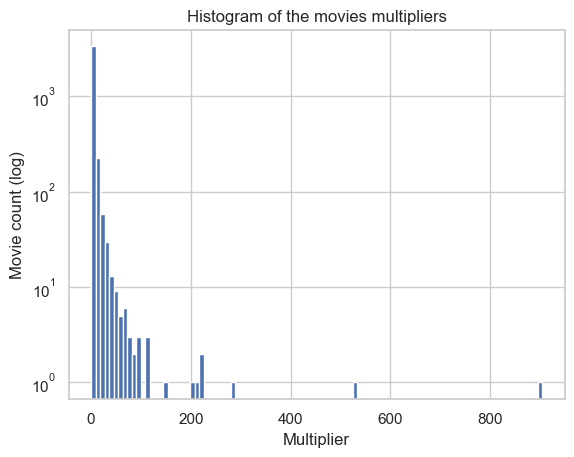

In [949]:
# Plot the multipliers distributions 
plt.hist(movie_features_no_outliers.multiplier, bins=100)
plt.title('Histogram of the movies multipliers')
plt.xlabel('Multiplier')
plt.ylabel('Movie count (log)')
plt.yscale('log')
plt.show()

We can also remove movies with budget lower than 10000$.

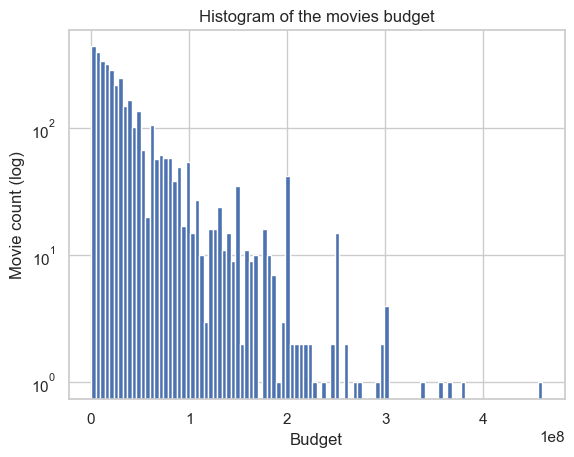

In [950]:
movie_features_no_outliers = movie_features_no_outliers[movie_features_no_outliers['budget'] > 10000]

# Plot the budget distributions 
plt.hist(movie_features_no_outliers.budget, bins=100)
plt.title('Histogram of the movies budget')
plt.xlabel('Budget')
plt.ylabel('Movie count (log)')
plt.yscale('log')
plt.show()

In [951]:
print('There remain {} movies in the movie_features_no_outliers dataset.'.format(len(movie_features_no_outliers)))

There remain 3712 movies in the movie_features_no_outliers dataset.


### Movie distribution over the years

In [952]:
# Convert the movies date of release to datetime
#movie_features_no_outliers['release_date'] = movie_features_no_outliers['release_date'].apply(convert_to_datetime)

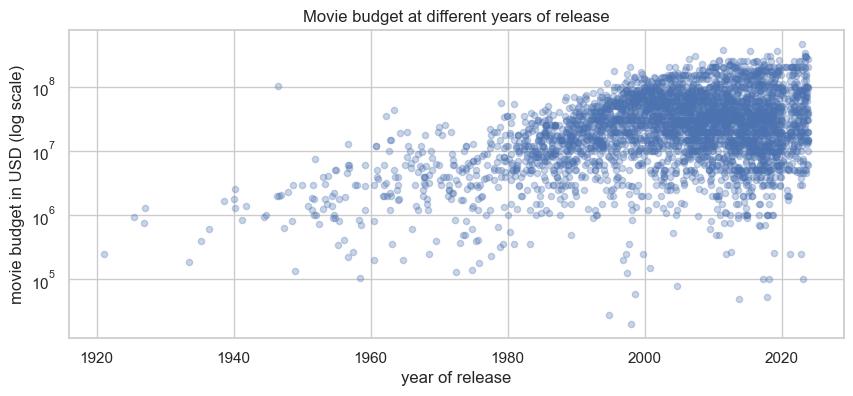

In [953]:
# Plot the movie budget at different years of release
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(movie_features_no_outliers['release_date'], movie_features_no_outliers['budget'], alpha=0.3, s=20)
plt.title('Movie budget at different years of release')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.show()

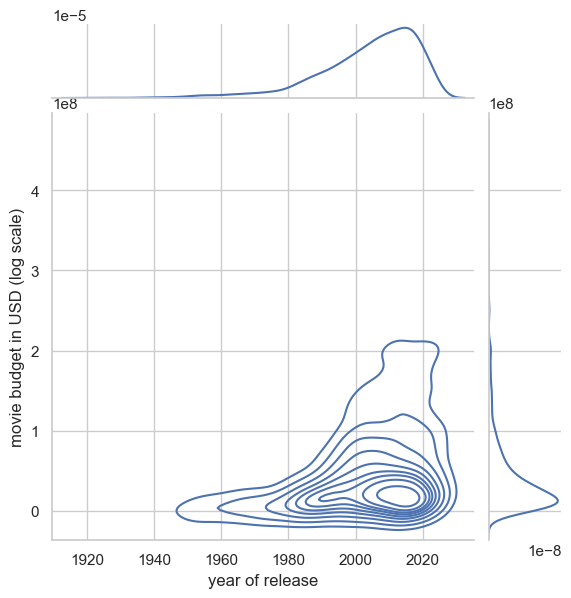

In [954]:
# Let's plot the movie budget in another way to better see the distribution
sns.jointplot(data=movie_features_no_outliers, x='release_date', y='budget', kind='kde').set_axis_labels('year of release', 'movie budget in USD (log scale)')
plt.show()

The scatterplot gave us a first insight about the data distribution over the years. The graph above draws both bivariate and univariate Kernel Density Estimations (KDEs) to have a smoother and cleaner representation of the movie budget data over the years.

### Removing old movies

Our objective is to identify how to maximize returns on investment nowadays. Considering older movies may introduce bias into our analysis, as they adhere to different norms, and audience preferences have evolved over time. We will then exclude all movies released before 1980 from our analysis.

In [955]:
# Remove old movies
new_movie_features = movie_features_no_outliers[movie_features_no_outliers['release_date'] > convert_to_datetime('1980')].copy()

### Separate in low and high budget categories

To distinguish between `low` and `high`-budget films, we categorize films into five-year groups based on their release dates. The top 40% of films with the highest budgets and the bottom 40% with the lowest budgets are then identified within each time frame. This process mitigates the impact of ***inflation*** on budget categorization. Subsequently, all high-budget films from different periods will be regrouped into a single high-budget category, and the same will be done for low-budget films.

In [956]:
min_year = new_movie_features['release_date'].min().year
max_year = new_movie_features['release_date'].max().year

# Create a new column corresponding to the year of release of the movie
new_movie_features['year'] = new_movie_features['release_date'].dt.year 
new_movie_features['year_group'] = new_movie_features['year']

df_low_budget_movie = pd.DataFrame(columns=new_movie_features.columns)
df_high_budget_movie = pd.DataFrame(columns=new_movie_features.columns)

year = min_year
while year < max_year:
    # Select movies released by 5 years interval
    movies = new_movie_features[(new_movie_features['year'] >= int(year)) & (new_movie_features['year'] < int(year + 5))]
    # Add the movies with the highest and lowest budget to the corresponding dataframe
    movies['year_group'] = year
    df_high_budget_movie = pd.concat([pd.DataFrame(movies[movies['budget'] > movies['budget'].quantile(0.6)]),df_high_budget_movie], ignore_index=True)
    df_low_budget_movie = pd.concat([pd.DataFrame(movies[movies['budget'] < movies['budget'].quantile(0.4)]),df_low_budget_movie], ignore_index=True)
    year += 5


C:\Users\saill\AppData\Local\Temp\ipykernel_15964\224010811.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\224010811.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\224010811.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

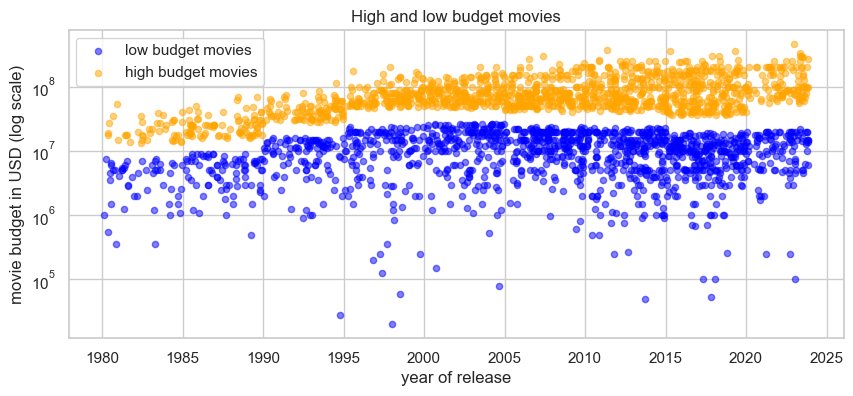

In [957]:
# Plot the high and low budget movies at different years of release
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df_low_budget_movie['release_date'], df_low_budget_movie['budget'], label='low budget movies', color='blue', alpha=0.5, s=20)
plt.scatter(df_high_budget_movie['release_date'], df_high_budget_movie['budget'], label='high budget movies', color='orange', alpha=0.5, s=20)
plt.title('High and low budget movies')
plt.xlabel('year of release')
plt.ylabel('movie budget in USD (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

We observe a distinct separation between `low` and `high` budgets. The graph illustrates that the definition of low and high budgets changes over the years, following a logarithmic function.


In [958]:
print('There are {} low budget movies.'.format(len(df_low_budget_movie)))
print('There are {} high budget movies.'.format(len(df_high_budget_movie)))

There are 1349 low budget movies.
There are 1308 high budget movies.


In [959]:
df_low_budget_movie['category'] = 'low'
df_high_budget_movie['category'] = 'high'
df = pd.concat([df_low_budget_movie, df_high_budget_movie], ignore_index=True) 

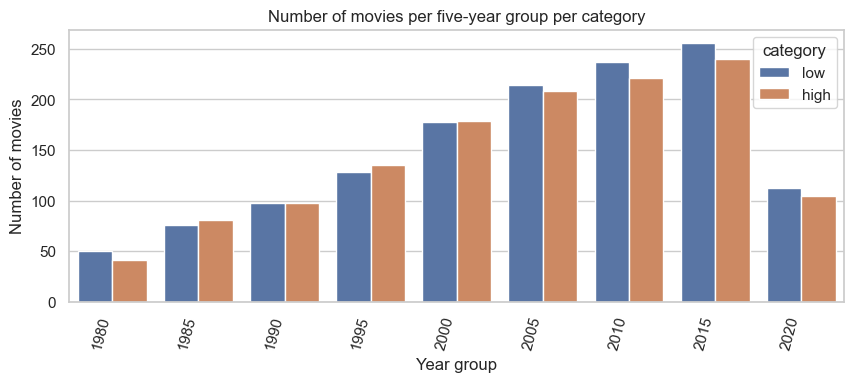

In [960]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='year_group', hue='category')
ax.set_title('Number of movies per five-year group per category')
ax.set_xlabel('Year group')
ax.set_ylabel('Number of movies')
fig.autofmt_xdate(rotation = 75)

By selecting the 40% lowest and highest values for each five-year group, we approximately have the same number of films from each year group. The higher count of films in recent years is attributed to the greater number of films recorded in the dataset from those years.

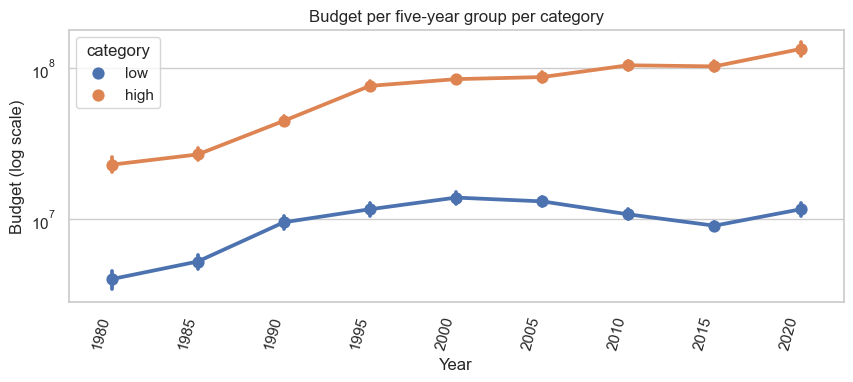

In [961]:
fig, ax = plt.subplots(figsize=(10, 4))

# Ploting the corresponding fraction of missing salary by year
sns.pointplot(data=df, x='year_group', y='budget', hue='category', errorbar=('ci', 95))

ax.set_title('Budget per five-year group per category')
ax.set_xlabel('Year')
ax.set_yscale('log')
ax.set_ylabel('Budget (log scale)')
ax.legend(title='category')

fig.autofmt_xdate(rotation = 75)

plt.show()

We can observe from the above graph that films with high and low budgets have non-overlapping 95% confidence intervals. This indicates that the films are effectively distinguished.

# Data visualisation

After cleaning and filtering the data, we are left with 1701 movies. 855 high budget movies and 846 low budget movies. Let's take a look at the distribution of the multiplier for both high and low budget movies.

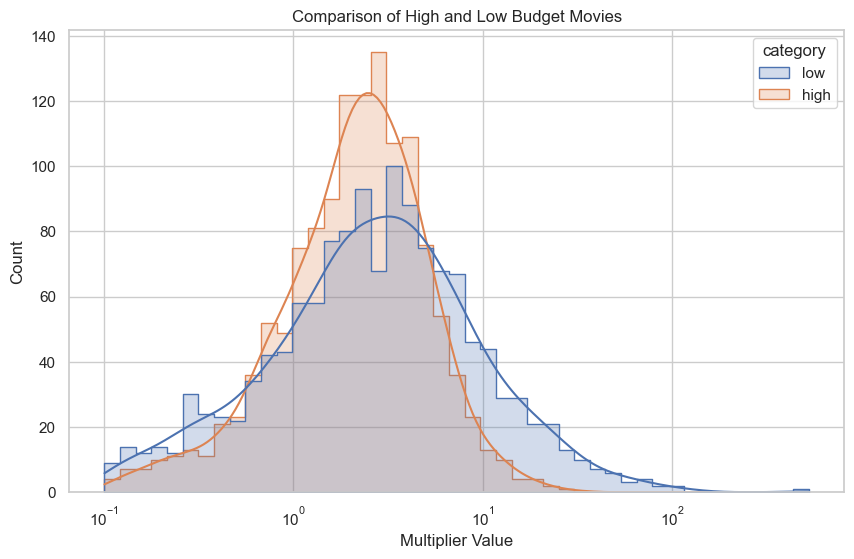

In [962]:
# Plot the multipliers of low and high budget movies 

sns.set(style="whitegrid")

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Create the histogram plot with Seaborn
sns.histplot(data=df, x="multiplier", hue="category", element="step", log_scale=(True, False), kde = True)

# Set the title and labels
plt.title("Comparison of High and Low Budget Movies")
plt.xlabel("Multiplier Value")
plt.ylabel("Count")
# Show the plot
plt.show()

Low-budget movies, in blue, typically yield more modest returns, but a select few outperform expectations with high profitability. High-budget films, in orange, show more consistent returns but fewer breakout financial successes.

### Movie genre

Let's look at the distribution of genres for both high and low budget movies.

In [963]:
# Plot the distribution of genres

# Separate movie genres
df_vis = df.copy()
df_vis = df_vis.explode('genres')

# Separate in high and low budgets
df_high_budget = df_vis[df_vis['category'] == 'high']
df_low_budget = df_vis[df_vis['category'] == 'low']

# Create pie charts for 'high' and 'low' categories
fig_high = px.pie(df_high_budget, names='genres', title='Genre distribution for high budget movies')
fig_low = px.pie(df_low_budget, names='genres', title='Genre distribution for low budget movies')

# Create a subplot with 1 row and 2 columns and specify the subplot type as 'domain'
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['High Budget', 'Low Budget'], specs=[[{'type': 'domain'}, {'type': 'domain'}]])

# Add the 'high' pie chart to the first column of the subplot
fig.add_trace(fig_high['data'][0], row=1, col=1)

# Add the 'low' pie chart to the second column of the subplot
fig.add_trace(fig_low['data'][0], row=1, col=2)


# Add a title to the entire subplot
fig.update_layout(title_text="Distribution of genre for high and low budget")

fig.show()

fig.write_html("./plots_html/pie_genre.html",include_plotlyjs = False)

The most popular genre are completely different for high and low budget. High budget top 5 genre are: Action, Adventure, Comedy, Drama and Thriller. Low budget top 5 genre are: Drama, Comedy, Thriller, Horror and Romance. The biggest difference exists in Horrow where only 1.42% of high budget movies are in this genre compared to 9.5% for low budget movies. Let's try and understand why this is the case.

In [964]:
# Plot the multiplier by genre

# Group by 'category' and 'genres' and calculate the mean of 'multiplier'
df_avg_multiplier_per_genre_and_budget = df_vis.groupby(['category', 'genres'])['multiplier'].mean().reset_index()

# Create a bar chart
fig = px.bar(df_avg_multiplier_per_genre_and_budget, x='genres', y='multiplier', color='category',
             labels={'genres': 'Genres', 'multiplier': 'Average Multiplier', 'category': 'Budget Category'},
             title='Average Multiplier by Genre and Budget Category')

# Update the layout to make the bars stand side by side
fig.update_layout(barmode='group')

fig.show()

fig.write_html("./plots_html/genre_influence_multiplier.html",include_plotlyjs = False)

We can explain the difference in the amount of horror films in low budget compared to high budget by looking at the multiplier difference. On average multiplier for horror films is 9.11 for low budget and 2.49 for high budget. This means that low budget horror films return on investement multiplier is at least 3x greater than any other genre of high budget films. We can hypothesize that this financial incentive is what drives the difference in the amount of horror films in low budget compared to high budget.

### Movie runtime

The Movie Runtime is the duration of the movie in minutes. Let's explore the distribution of runtime for both high and low budget movies and it's relation to the multiplier.

In [965]:
# Plot the multiplier vs runtime

fig = px.scatter(df, x='runtime', y='multiplier', color='category',
                 labels={'runtime': 'Runtime', 'multiplier': 'Multiplier'},
                 title='Multiplier by runtime', log_y=True)
fig.show()

The scatter plot compares the financial multiplier against the runtime for high (red) and low (blue) budget films. Most films cluster around the 90-120 minute mark, reflecting a standard movie length. High-budget films show some outliers with high multipliers and longer runtimes, suggesting blockbuster potential for epic-scale movies. Low-budget films also have outliers with high multipliers, indicating potential sleeper hits. Both high and low-budget categories show a wide scatter, implying that runtime alone is not a strong predictor of financial success. Overall, while there are high-performing movies at various lengths, the majority of films from both budget categories tend to have moderate runtimes and multipliers. This suggests that factors other than runtime may be more critical in determining a movie's financial performance.

### Movie age and sex

In [967]:
# Plot the multiplier vs average age

fig = px.scatter(df, x='average_age', y='multiplier', color='category',
                 labels={'average_age': 'Average actors age', 'multiplier': 'Multiplier'},
                 title='Multiplier by actors average age', log_y=True, )

fig.show()

In [968]:
# Plot the multiplier vs male ratio

fig = px.scatter(df, x='male_ratio', y='multiplier', color='category',
                 labels={'male_ratio': 'Male ratio', 'multiplier': 'Multiplier'},
                 title='Multiplier by male ratio', log_y=True)
fig.show()

The first scatter plot explores the relationship between a film's financial multiplier and average actor's age. Low budget movies tend to have younger actors, probably because young and unexperienced actors are less expensive. The age doesn't consistently yield higher or lower returns for either budget category. 

In the second scatter plot, examining the multiplier against the male ratio within the cast, a similar pattern emerges: there's no discernible trend that a higher proportion of male actors correlates with financial success. Both high and low-budget films are dispersed throughout the plots, suggesting that the age and gender composition of the cast have a minimal direct impact on a movie's return on investment. This data implies that casting decisions regarding age and gender are likely based on creative rather than financial considerations.

We'll use other features related to the actor's age : the ratio of young (below 18 years old) and old (above 60 years old) actors in the movie, as well as the minimum and maximum age in each movie.

### Mean actor's experience and popularity

In [969]:
# Plot the multiplier vs actor's experience

fig = px.scatter(df, x='average_actor_exp', y='multiplier', color='category',
                 labels={'average_actor_exp': 'Mean actors experience', 'multiplier': 'Multiplier'},
                 title='Multiplier by average actors experience', log_y=True)
fig.show()

In [970]:
# Plot the multiplier vs actor's popularity

fig = px.scatter(df, x='average_popularity', y='multiplier', color='category',
                 labels={'average_popularity': 'Mean actors popularity', 'multiplier': 'Multiplier'},
                 title='Multiplier by actors popularity', log_y=True)
fig.show()

Those scatter plots compare the multiplier against the average actor's experience and popularity. The actor's mean experience is calculated by averaging over all actors in the movie, the number of films the actors have appeared before. Low budget movies tend to have less experienced and popular actors compared to high budget movies. For high budget movies, a high actor's experience seems to have positive an impact on the multiplier. For low budget movies, the multiplier shows more variability depending on actor's experience. 

We will also include in our analysis the minimum and maximum in each movie of actor's experience and popularity, as well as the total number of characters. 

### Spoken languages count

In [971]:
# Plot the multiplier vs spoken languages count

fig = px.scatter(df, x='spoken_languages_count', y='multiplier', color='category',
                 labels={'spoken_languages_count': 'Spoken languages count', 'multiplier': 'Multiplier'},
                 title='Multiplier by spoken languages count', log_y=True)
fig.show()

A higher number of spoken languages in a movie seems to induce lower multipliers for both low and high budget movies. 

Our analysis will also include other features : the original language and countries of production, the title word count and the quarter when the movie was released. 

### Initial overall perception

Low-budget films exhibit a greater variance in financial returns, indicating a higher risk but also the potential for significant profit, as seen in the broader spread of multipliers. In contrast, high-budget movies show more predictable returns, suggesting a lower risk but also a lower relative profitability. Genre preferences differ distinctly between the two, with low-budget films favoring genres like Horror that offer high returns at lower costs. Although movie runtime does not strongly correlate with financial success, both high and low-budget films typically adhere to standard feature-length times. This data implies that while high-budget films offer stability, low-budget films provide the allure of high rewards, driving diverse production strategies in the film industry. However we only looked at the data from a high level. Let's dive deeper into the data and see if we can find more insights. What are the most important features that drive the multiplier?

# Statistical analysis

## Which features of a movie have a significant effect on its box office revenue with respect to its cost?

In [972]:
display(df.head())

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages,...,average_popularity,max_popularity,min_popularity,average_actor_exp,min_actor_exp,max_actor_exp,multiplier,year,year_group,category
0,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"[Horror, Mystery]",[United States of America],[English],...,56.929800,147.890,16.509,5.600000,0.0,14.0,13.595000,2023,2020,low
1,951491.0,Saw X,13000000.0,100900000.0,2023-09-26,118.0,en,"[Horror, Thriller]",[United States of America],"[Norsk, Español, English]",...,22.167857,32.931,13.700,5.857143,0.0,11.0,7.761538,2023,2020,low
2,762430.0,Retribution,20000000.0,16700000.0,2023-08-23,91.0,en,"[Action, Thriller, Crime]","[France, Germany, United States of America]","[Deutsch, English]",...,39.837857,155.962,11.088,9.142857,0.0,41.0,0.835000,2023,2020,low
3,678512.0,Sound of Freedom,14500000.0,247800000.0,2023-07-03,131.0,en,"[Action, Drama]",[United States of America],"[English, Español]",...,17.398429,27.814,10.613,7.285714,1.0,13.0,17.089655,2023,2020,low
4,820525.0,After Everything,14000000.0,9700000.0,2023-09-13,93.0,en,"[Romance, Drama]",[United States of America],"[English, Português]",...,23.053900,37.079,14.440,3.200000,0.0,8.0,0.692857,2023,2020,low


In [973]:
original_language_onehot = pd.get_dummies(df['original_language'], prefix='onehot', prefix_sep='_')
df = pd.concat([df, original_language_onehot], axis=1)

In [974]:
def get_column_per_value(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Extract unique genres
    unique_genres = set(genre for genres_list in df[column_name] for genre in genres_list)

    # Create one-hot encoded columns for each genre
    for genre in unique_genres:
        df[f'onehot_{column_name}_' + genre.lower()] = df[column_name].apply(lambda x: 1 if genre in x else 0)

In [975]:
get_column_per_value(df, 'genres')
get_column_per_value(df, 'production_countries')

We convert all boolean columns to integer type to ensure uniform data types across all columns.

In [976]:
# convert boolean to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

In [977]:
df.rename(columns={"onehot_genres_science fiction": "onehot_genres_science_fiction", "onehot_production_countries_united states of america": "onehot_production_countries_united_states_of_america", "onehot_production_countries_hong kong": "onehot_production_countries_hong_kong", "onehot_production_countries_united kingdom": "onehot_production_countries_united_kingdom"}, inplace=True)

### Get the input and ouput data for our model

We generate the `input_df` by ***excluding*** features that producers cannot influence, along with the column for which we generated dummy variables. Additionally, we establish the `output_df` variable, which represents the `multiplier`.

In [978]:
input_df = df.drop(['multiplier','budget', 'revenue', 'movie_id', 'release_date', 'title', 'year', 'year_group', 'genres', 'original_language', 'production_countries', 'spoken_languages'], axis=1)
display(input_df.head())
output_df = df['multiplier']

,runtime,title_word_count,spoken_languages_count,release_quarter,number_characters,below18,above60,male_ratio,average_age,max_age,...,onehot_production_countries_botswana,onehot_production_countries_united arab emirates,onehot_production_countries_turkey,onehot_production_countries_spain,onehot_production_countries_belgium,onehot_production_countries_kazakhstan,onehot_production_countries_slovenia,onehot_production_countries_iceland,onehot_production_countries_france,onehot_production_countries_south korea
0,110.0,4,1,4,5.0,0.200000,0.000000,0.600000,36.800000,57.0,...,0,0,0,0,0,0,0,0,0,0
1,118.0,2,3,3,7.0,0.000000,0.142857,0.571429,54.000000,81.0,...,0,0,0,0,0,0,0,0,0,0
2,91.0,1,2,3,7.0,0.142857,0.285714,0.428571,43.285714,71.0,...,0,0,0,0,0,0,0,0,1,0
3,131.0,3,2,3,7.0,0.000000,0.142857,0.857143,53.000000,70.0,...,0,0,0,0,0,0,0,0,0,0
4,93.0,2,2,3,10.0,0.000000,0.000000,0.500000,37.100000,60.0,...,0,0,0,0,0,0,0,0,0,0


We generate two distinct dataframes, one for each category of low and high budgets.

In [979]:
input_l = input_df[input_df['category'] == 'low'].drop(['category'], axis=1)
input_h = input_df[input_df['category'] == 'high'].drop(['category'], axis=1)
output_l = output_df[input_df['category'] == 'low']
output_h = output_df[input_df['category'] == 'high']

For each category, we eliminate outliers, specifically targeting exceptionally low budgets for the low-budget category and exceptionally high ones for the high-budget category.

In [980]:
def remove_outliers(input, output, low=0.2, high=0.8):
    threshold_low = output.quantile(low)
    threshold_high = output.quantile(high)
    input = input[output < threshold_high]
    input = input[output > threshold_low]
    output = output[output < threshold_high]
    output = output[output > threshold_low]
    return input, output

In [981]:
input_low, output_low = remove_outliers(input_l, output_l, low=0.2, high=1)
input_high, output_high = remove_outliers(input_h, output_h, low=0.2, high=0.8)

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\2873073568.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\2873073568.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



We remove the the onehot features column where we have less than 20 values because that means that we will have less than 20 film corresponding to the category and we consider that it is not enaugh to generalize.

In [982]:
print(input_low)

      runtime title_word_count spoken_languages_count release_quarter  \
0       110.0                4                      1               4   
1       118.0                2                      3               3   
3       131.0                3                      2               3   
5        95.0                3                      2               3   
6       127.0                1                      1               4   
...       ...              ...                    ...             ...   
1344    103.0                1                      1               1   
1345     88.0                1                      1               4   
1346    100.0                1                      2               2   
1347    112.0                1                      2               3   
1348     97.0                1                      1               3   

      number_characters  below18   above60  male_ratio  average_age  max_age  \
0                   5.0    0.200  0.000000 

In [983]:
for col in input_high.columns:
    if (input_high[col].sum() < 10) and ('onehot' in col):
        # print(col)
        input_high.drop(col, axis=1, inplace=True)

In [984]:
for col in input_low.columns:
    if (input_low[col].sum() < 10) and ('onehot' in col):
        # print(col)
        input_low.drop(col, axis=1, inplace=True)

### Min Max scaling

We scale our column with minmax scaling the column to be have comparable range of [0,1] between all the features and not have some artefacts due to the fact that one feature is a lot bigger than the others.
We store the scaler to be able to reverse the scaling at the end of the optimisation.

We use this scaling method and not standardization of normalization, because the minmax scaling does not reduce the effect of outliers, but it linearily scales them down into a fixed range. this is good in our case because we want the model to not overfit the outliers and so to keep them as 'outliers'.

Use inverse_transform(X) to get the original values.

In [985]:
def minmax_scale_input(input):
    scaler = MinMaxScaler()
    scaler.fit(input)
    minmax_input = pd.DataFrame(scaler.transform(input))
    minmax_input.columns = input.columns
    minmax_input.index = input.index
    return minmax_input, scaler

In [986]:
scaled_input_low, scaler_low_budget = minmax_scale_input(input_low)
scaled_input_high, scaler_high_budget = minmax_scale_input(input_high)

### Log transformation of the output

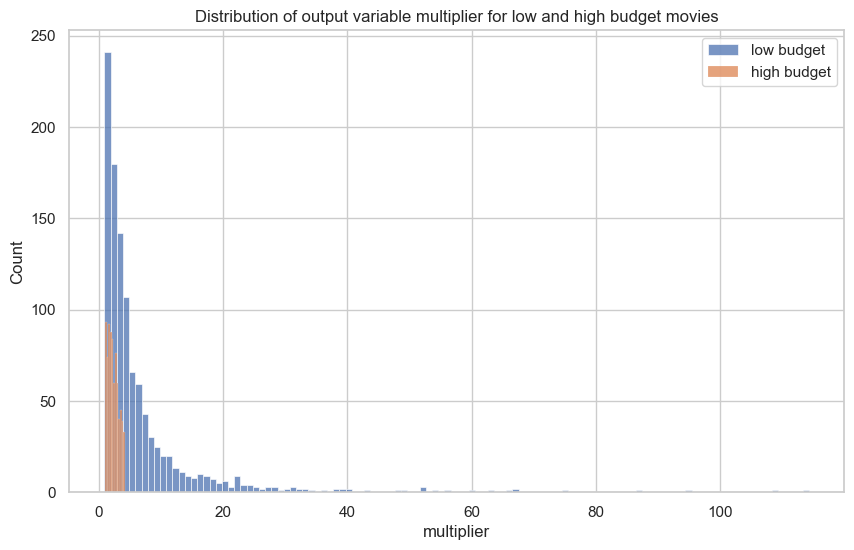

In [987]:
# plot the disitribution of output variable for low and high budget movies
plt.figure(figsize=(10, 6))
sns.histplot(output_low, label='low budget')
sns.histplot(output_high, label='high budget')
plt.title('Distribution of output variable multiplier for low and high budget movies')
plt.legend()
plt.show()

We can see from the distribution above that our `multiplier` distribution is skewed, especially for the low budget category. If the distribution of the output variable is highly skewed, applying a log transformation can help make the distribution more symmetric. This is particularly useful when dealing with models that assume a normal distribution of errors (e.g., linear regression). In regression modeling, a log transformation can linearize relationships between variables. This can be advantageous if the underlying relationship between the predictors and the output is better approximated by a linear model after the log transformation.

In [988]:
log_output_low = np.log(output_low)
log_output_high = np.log(output_high)

### Model definition

For the next parts we will use a linear regression model.

In [989]:
def compute_model(input, output, plot_summary=False, test_set=False):
    if test_set:
        X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.15, random_state=42)
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        y_pred = results.predict(X_test)
        print('The R2 score for the test set is: ', r2_score(y_test, y_pred))
    else:
        model = sm.OLS(output, input)
        results = model.fit()
    if plot_summary:
        print(results.summary())
    return results

### Model testing

#### Best for high

In [990]:
scaled_input_high = sm.add_constant(scaled_input_high)
compute_model(scaled_input_high, log_output_high, plot_summary=True, test_set=True)

The R2 score for the test set is:  0.21874616828771054
                            OLS Regression Results                            
Dep. Variable:             multiplier   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.709
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00332
Time:                        10:52:08   Log-Likelihood:                -256.01
No. Observations:                 666   AIC:                             604.0
Df Residuals:                     620   BIC:                             811.1
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

#### Best for low

In [991]:
scaled_input_low = sm.add_constant(scaled_input_low)
compute_model(scaled_input_low, log_output_low, plot_summary=True, test_set=True)

The R2 score for the test set is:  0.015393708774638415
                            OLS Regression Results                            
Dep. Variable:             multiplier   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.193
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.40e-06
Time:                        10:52:08   Log-Likelihood:                -1155.4
No. Observations:                 916   AIC:                             2431.
Df Residuals:                     856   BIC:                             2720.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

### Feature selection

#### Low budget movies

We will look at correlation between variables to see if there are some high correlated terms. 

In [992]:
# find pairs of features with correlation greater than 0.6
corr_matrix = scaled_input_low.corr().abs()
corr_matrix = corr_matrix.unstack().reset_index()
corr_matrix.columns = ['feature_1', 'feature_2', 'correlation']
corr_matrix = corr_matrix[corr_matrix['feature_1'] != corr_matrix['feature_2']]
corr_matrix = corr_matrix.sort_values(by='correlation', ascending=False)
corr_matrix = corr_matrix[corr_matrix['correlation'] > 0.6]
corr_matrix

,feature_1,feature_2,correlation
3683,onehot_production_countries_south korea,onehot_ko,1.000000
1463,onehot_ko,onehot_production_countries_south korea,1.000000
3285,onehot_production_countries_denmark,onehot_production_countries_sweden,0.960318
3225,onehot_production_countries_sweden,onehot_production_countries_denmark,0.960318
1332,onehot_hi,onehot_production_countries_india,0.874961
3132,onehot_production_countries_india,onehot_hi,0.874961
1052,max_actor_exp,average_actor_exp,0.859770
932,average_actor_exp,max_actor_exp,0.859770
1139,onehot_en,onehot_production_countries_united_states_of_a...,0.781785
2519,onehot_production_countries_united_states_of_a...,onehot_en,0.781785


We can see that some of the features are highly correlated so we will include the interaction between them in the model.

In [993]:
results = compute_model(scaled_input_low, log_output_low)

# feature names
variables = results.params.index
# coefficients
coefficients = results.params.values
# p-values
p_values = results.pvalues
# standard errors
standard_errors = results.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

In [994]:
def plot_predictors(l1, l2, l3, category_name = 'low'): 
    plt.figure(figsize=(12,14))
    plt.errorbar(l1, np.array(range(len(l1))), xerr= np.array(l3), linewidth = 1,
                linestyle = 'none',marker = 'o',markersize= 3,
                markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')
    plt.yticks(range(len(l2)),l2)
    plt.title(f'Effect of the predictors on the log of the revenue multiplier for the {category_name} budget movies')
    plt.xlabel('Coefficient')
    plt.ylabel('Predictor')
    plt.show()

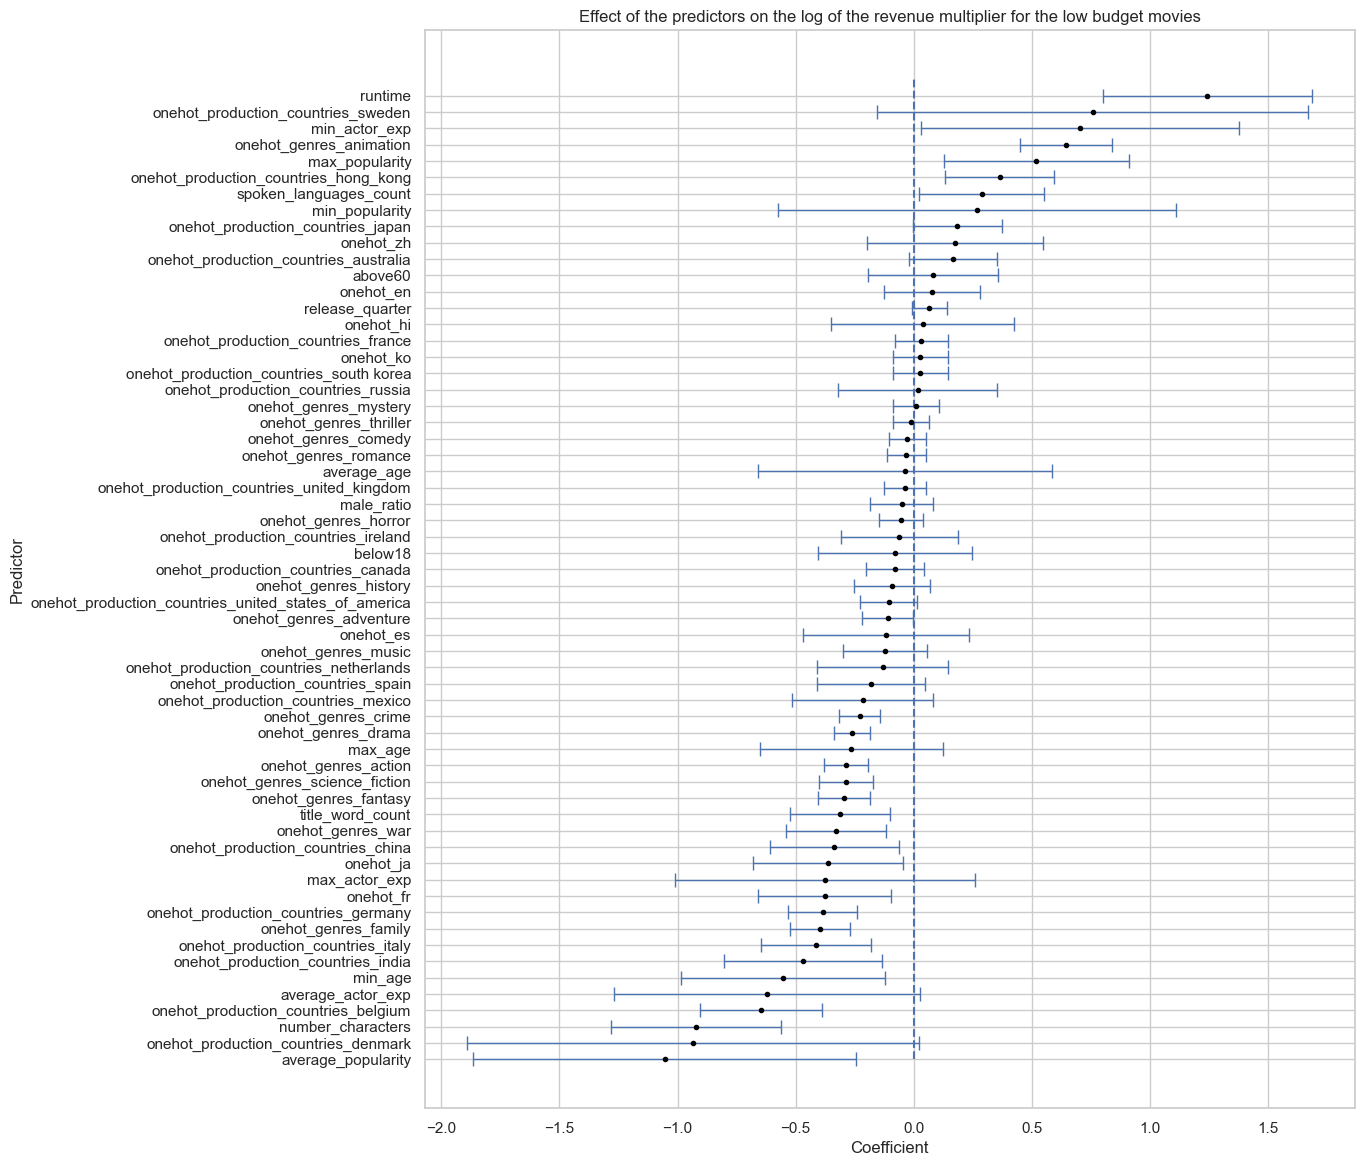

In [995]:
plot_predictors(l1, l2, l3, category_name = 'low')

We can see from the graph above that some features are not significant and the confidence interval are crossing the 0 so we are not sure if the correlation with the output is positive or negative. That is why we are choosing to remove these variables and keep only features that are significant and have positive or negative correlation with the output.

We decide to take a 68% = 1 std confidence intervals to include more variables, and be less strict of the feature selection.

In [996]:
#keep only the significant variables so values that are in 68% confidence interval (1 standard deviation)
significant_variables = variables[1:][np.abs(coefficients[1:]) > 1*standard_errors[1:]]
significant_variables

Index(['runtime', 'title_word_count', 'spoken_languages_count',
       'number_characters', 'min_age', 'average_popularity', 'max_popularity',
       'min_actor_exp', 'onehot_fr', 'onehot_ja', 'onehot_genres_crime',
       'onehot_genres_drama', 'onehot_genres_animation',
       'onehot_genres_action', 'onehot_genres_fantasy', 'onehot_genres_war',
       'onehot_genres_adventure', 'onehot_genres_science_fiction',
       'onehot_genres_family', 'onehot_production_countries_china',
       'onehot_production_countries_hong_kong',
       'onehot_production_countries_italy',
       'onehot_production_countries_germany',
       'onehot_production_countries_india',
       'onehot_production_countries_belgium'],
      dtype='object')

In [997]:
df_l = pd.concat([scaled_input_low, log_output_low], axis=1)
df_l.columns = list(scaled_input_low.columns) + ['logmultiplier']
mod_low = smf.ols(formula= ' logmultiplier ~ runtime+ number_characters*min_age*average_popularity*max_popularity*min_actor_exp+title_word_count*spoken_languages_count*onehot_fr*onehot_ja+onehot_genres_adventure*onehot_genres_science_fiction*onehot_genres_crime*onehot_genres_drama*onehot_genres_action*onehot_genres_animation*onehot_genres_war*onehot_genres_family*onehot_genres_fantasy+onehot_production_countries_germany*onehot_production_countries_india*onehot_production_countries_italy*onehot_production_countries_china*onehot_production_countries_hong_kong*onehot_production_countries_belgium',            data=df_l)

results_regression_low = mod_low.fit()
print('R-squared:', results_regression_low.rsquared)

R-squared: 0.17069366480341153


We can see that by keeping only features that are in the 68% confidence interval and adding their interactions terms we augmented the explained variance. We will keep this model for the following parts.

In [998]:
for result in results_regression_low.params.index:
    if result not in input_low.columns:
        input_low[result] = 1
        parts = split_string(result)
        for part in parts:
            input_low[result] = input_low[result] * input_low[part]
input_low = input_low[results_regression_low.params.index]
desired_column_order = results_regression_low.params.index
# Reorder the columns 
input_low = input_low[desired_column_order]

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\2520544224.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\2520544224.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\2520544224.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [999]:
variables = results_regression_low.params.index
# keep significant values only (p-value < 0.05)
significant_variables_low = variables[1:][results_regression_low.pvalues[1:] < 0.05]

In [1000]:
#plot percentage of explained variance for each variable
fig = go.Figure(go.Bar(
    y=significant_variables_low,
    x=results_regression_low.pvalues[1:][results_regression_low.pvalues[1:] < 0.05],
    orientation='h',  
    marker=dict(color='blue')
))

fig.update_layout(
    title='Percentage of Explained Variance for the Most Significant Variables for the High Budget Movies',
    xaxis_title='Percentage of Explained Variance',
    yaxis_title='Variable',
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(significant_variables_low))),
        ticktext=significant_variables_low
    ),
    margin=dict(
    l=50,
    r=50, 
    b=25,  
    t=40, 
    pad=4   
    )
)
# Showing the figure
fig.show()


We decide to keep the most important features with interactions terms for the predictions, as these are the most significant features that explain the trend on the output.

In [1001]:
input_low = input_low[significant_variables_low]
print(input_low.shape)
scaled_input_low, scaler_low = minmax_scale_input(input_low)
final_model_low = compute_model(scaled_input_low, log_output_low)

(1078, 33)


#### High budget movies

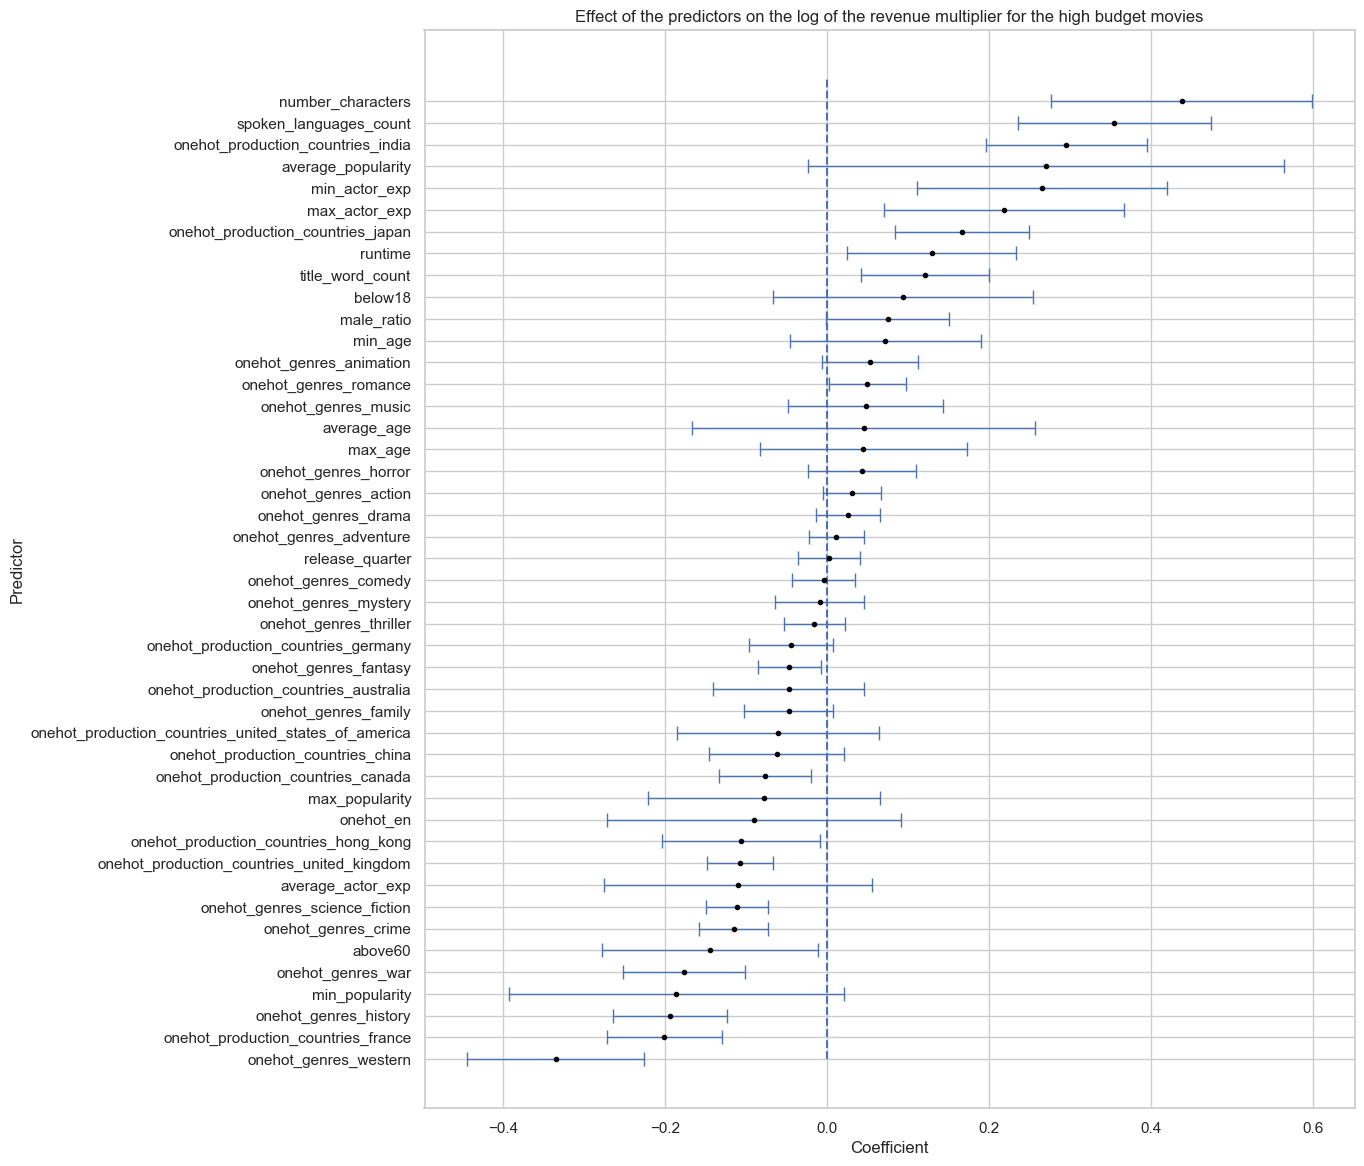

In [1002]:
results = compute_model(scaled_input_high, log_output_high)

# feature names
variables = results.params.index
# coefficients
coefficients = results.params.values
# p-values
p_values = results.pvalues
# standard errors
standard_errors = results.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
plot_predictors(l1, l2, l3, category_name = 'high')

In [1003]:
#keep only the significant variables so values that are in 68% confidence interval (1 standard deviation)
significant_variables = variables[1:][np.abs(coefficients[1:]) > 1*standard_errors[1:]]
significant_variables

Index(['runtime', 'title_word_count', 'spoken_languages_count',
       'number_characters', 'above60', 'min_actor_exp', 'max_actor_exp',
       'onehot_genres_crime', 'onehot_genres_history', 'onehot_genres_western',
       'onehot_genres_romance', 'onehot_genres_fantasy', 'onehot_genres_war',
       'onehot_genres_science_fiction',
       'onehot_production_countries_united_kingdom',
       'onehot_production_countries_hong_kong',
       'onehot_production_countries_japan',
       'onehot_production_countries_canada',
       'onehot_production_countries_india',
       'onehot_production_countries_france'],
      dtype='object')

In [1004]:
df_h = pd.concat([scaled_input_high, log_output_high], axis=1)
df_h.columns = list(scaled_input_high.columns) + ['logmultiplier']
mod_high = smf.ols(formula= ' logmultiplier ~ runtime + number_characters*above60*min_actor_exp*max_actor_exp+title_word_count*spoken_languages_count+ onehot_genres_history*onehot_genres_science_fiction*onehot_genres_crime*onehot_genres_western*onehot_genres_war*onehot_genres_romance*onehot_genres_fantasy + onehot_production_countries_united_kingdom+onehot_production_countries_japan+onehot_production_countries_india+onehot_production_countries_canada+onehot_production_countries_france+onehot_production_countries_hong_kong',            data=df_h)

results_regression_high = mod_high.fit()
print('R-squared:', results_regression_high.rsquared)

R-squared: 0.15202824565916662


We can see that by adding the interaction terms, the R-squared value increases from 0.131 to 0.152. From all these features and interactions we will keep the most significant ones for the prediction.

In [1005]:
for result in results_regression_high.params.index:
    if result not in input_high.columns:
        input_high[result] = 1
        parts = split_string(result)
        for part in parts:
            input_high[result] = input_high[result] * input_high[part]
input_high = input_high[results_regression_high.params.index]
desired_column_order = results_regression_high.params.index
# Reorder the columns 
input_high = input_high[desired_column_order]

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\4215559908.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\4215559908.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\saill\AppData\Local\Temp\ipykernel_15964\4215559908.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [1006]:
variables = results_regression_high.params.index
# keep significant values only (p-value < 0.1)
significant_variables_model_high = variables[1:][results_regression_high.pvalues[1:] < 0.1]

In [1007]:
#plot percentage of explained variance for each variable
fig = go.Figure(go.Bar(
    y=significant_variables_model_high,
    x=results_regression_high.pvalues[1:][results_regression_high.pvalues[1:] < 0.1],
    orientation='h', 
    marker=dict(color='blue')
))

fig.update_layout(
    title='Percentage of Explained Variance for the Most Significant Variables for the High Budget Movies',
    xaxis_title='Percentage of Explained Variance',
    yaxis_title='Variable',
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(significant_variables_model_high))),
        ticktext=significant_variables_model_high
    ),
    margin=dict(
    l=50,
    r=50,  
    b=25,  
    t=40, 
    pad=4   
    )
)
fig.show()

In [1008]:
input_high = input_high[significant_variables_model_high]
scaled_input_high, scaler_high = minmax_scale_input(input_high)
final_model_high = compute_model(scaled_input_high, log_output_high)

## Is there a common strategy among low and high budget movies to maximize their multipliers or is it different? If so, in which aspect(s) of the movie?

### Classification

If we split the multipliers into 3 categories that are the low, medium and high values of the `multiplier`, we can try to perform a classification. We could then see if we arrive to predict if the multiplier will be low or high from the features.

In [1009]:
class_output_low = pd.qcut(log_output_low, 3, labels=['low', 'medium', 'high'])
class_output_high = pd.qcut(log_output_high, 3, labels=['low', 'medium', 'high'])

In [1010]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error


X = scaled_input_high  # Two features for simplicity
y = class_output_high # Binary classification based on a simple condition

# Split the data into training and testing sets
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.37

Classification Report:
              precision    recall  f1-score   support

        high       0.32      0.32      0.32        65
         low       0.42      0.42      0.42        69
      medium       0.37      0.37      0.37        62

    accuracy                           0.37       196
   macro avg       0.37      0.37      0.37       196
weighted avg       0.37      0.37      0.37       196



We can see from the classification above that the accuracy of 38% is quite low given that with 3 balanced classes the random chance would be arounf 33%. We can still see that the f1-score for the class of high multiplier are higher than the medium class. It signifies that the model is performing better in terms of both precision and recall for that particular class. This could mean that we are more able to identify the features that will give a high multiplier.

### Optimisation for linear regression

We have seen in the previous part that the model that obtains the highest R-square score of and so the model that have the highest explained variance is the linear model. We know that this model can be an overfit, but it can give us some idea of the best choice to make for the producers. 
We will then use the linear model to predict the maximal `multiplier` the producers can obtain. We will also be able to give them the best features to have for their film to achieve this multiplier. 

#### Model for the high budget

From the linear model we are using the coeficients estimated.

In [1011]:
# these are the parameters for the model prediction
final_model_high.params

runtime                                                1.695020
spoken_languages_count                                 0.506240
onehot_genres_science_fiction                          0.116664
onehot_genres_crime                                    0.056181
onehot_genres_western                                 -0.270452
onehot_genres_science_fiction:onehot_genres_western   -0.297672
onehot_genres_crime:onehot_genres_fantasy              0.234764
onehot_production_countries_united_kingdom            -0.045118
onehot_production_countries_japan                      0.167692
onehot_production_countries_india                      0.184619
onehot_production_countries_canada                     0.047860
onehot_production_countries_france                    -0.252170
dtype: float64

##### Set bounds

We have to set the bounds for the optimisation. Since we scaled the features to [0,1] the bounds are simply [0,1].

In [1012]:
bounds = []
for attribute in range(len(final_model_high.params)):
    bounds.append((0, 1))

##### Define initial guess

For the optimisation to work we have to define an initial guess. In our case we want to have the maximal `multiplier` as possible so we can use the maximal `multiplier` of our dataset as the initial guess of max multiplier.

In [1013]:
def find_init_guess(input, output, name_output_column = 'multiplier'):
    '''
    Find the initial guess for the optimization algorithm
    :param dataframe: dataframe with the data
    :param name_output_column: name of the output column to maximize
    :return: initial guess of the features to maximize the output, the max value of the output and the index of the max value
    '''
    dataframe = pd.concat([input, output], axis=1)
    max = dataframe[name_output_column].max()
    idx_max = dataframe[name_output_column].idxmax()
    features = dataframe.loc[idx_max].drop(name_output_column).values
    return features, max, idx_max

In [1014]:
init_features, initial_max, _ = find_init_guess(scaled_input_high, log_output_high)

##### Perform optimization

Now we perform the optimisation. We want to have the max value of the `multiplier`. The function *optimise.minimize* is a minimization function so we will simply add a - sign at the model prediction to have a maximization of the output. The model_prediction is then the sum of the coeficients founs by the linear regression model times the features.

In [1015]:
from scipy import optimize

# Your trained model
def model_prediction(features):
    df_features = pd.DataFrame(features.reshape(1, -1), columns=final_model_high.params.index)
    prediction = final_model_high.predict(df_features)
    return prediction

# Objective function for optimization
def objective_function(features):
    return -model_prediction(features)  #Minimize the negative of the output


# Optimize feature values
result = optimize.minimize(objective_function, init_features, method='SLSQP', bounds=bounds)#, constraints=[integer_constraint] , options={'eps': 0.1})

# Optimized feature values
optimized_features = result.x

# Evaluate the model with optimized features
optimized_output = model_prediction(optimized_features)

In [1016]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.009039870801501
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  3.928e-16
            2.898e-16  1.000e+00  2.637e-15  1.000e+00  1.000e+00
            1.000e+00  0.000e+00]
     nit: 9
     jac: [-1.695e+00 -5.062e-01 -1.167e-01 -5.618e-02  2.705e-01
            2.977e-01 -2.348e-01  4.512e-02 -1.677e-01 -1.846e-01
           -4.786e-02  2.522e-01]
    nfev: 117
    njev: 9

We can see that the optimisation terminated sucessfully.

Then we rescale to the original scale the features to have the real features values.

In [1017]:
optimized_features_original_scale = scaler_high.inverse_transform([optimized_features])
init_features_original_scale = scaler_high.inverse_transform([init_features])

We apply an exponential to the log output to have the original value of multiplier.

In [1018]:
optimized_output_exp = np.exp(optimized_output)
initial_max_exp = np.exp(initial_max)

We look at the difference in results between the initial guess and the optimize features.

In [1019]:
print("10 first optimized features: {}".format(np.around(optimized_features_original_scale[0], 3)))
print("Optimized output: {}".format(np.around(optimized_output_exp, decimals=3)))
print("10 first initial features: {}".format(np.around(init_features_original_scale[0], decimals=3)))
print("Initial output: {}".format(initial_max_exp, decimals=3))

10 first optimized features: [191.  11.   1.   1.   0.   0.   1.   0.   1.   1.   1.   0.]
Optimized output: 0    20.268
dtype: float64
10 first initial features: [169.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
Initial output: 4.252904278787879


The prediction of maximal multiplier is `optimized_output`.

In [1020]:
print(optimized_output_exp)

0    20.267931
dtype: float64


In [1021]:
# Table of the optimized features

# Data for the table
features = [
    "runtime", "spoken_languages_count", "onehot_genres_science_fiction", 
    "onehot_genres_crime", "onehot_genres_western", 
    "onehot_genres_science_fiction:onehot_genres_western", 
    "onehot_genres_crime:onehot_genres_fantasy", 
    "onehot_production_countries_united_kingdom", 
    "onehot_production_countries_japan", "onehot_production_countries_india", 
    "onehot_production_countries_canada", "onehot_production_countries_france"
]

values = optimized_features_original_scale[0]
values = [0 if abs(x) < 1e-10 else 1 if abs(x - 1) < 1e-10 else x for x in optimized_features_original_scale[0]]

# Creating the table
fig = go.Figure(data=[go.Table(
    columnwidth=[2, 1],  
    header=dict(values=['Variable', 'Value'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[features, values],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(
     title='Optimal features in high budget movies',
     width=800, height=600)
fig.show()


The advised features for high budget movies are shown in this table, we can then advise John. The optimal runtime is around 190 min, and he should favors a movie with multiple spoken languages (around 11). The genres he should try are science fiction, crime or a combinaison of crime and fantasy, and he should avoid westerns. 

#### Model for the low budget

In [1022]:
bounds = []
for column in scaled_input_low.columns:
    bounds.append((0, 1))

init_features_low, initial_max_low, _ = find_init_guess(scaled_input_low, log_output_low)

# Your trained model
def model_prediction_low(features):
    df_features = pd.DataFrame(features.reshape(1, -1), columns=final_model_low.params.index)
    prediction = final_model_low.predict(df_features)
    return prediction

# Objective function for optimization
def objective_function_low(features):
    return -model_prediction_low(features)  #Minimize the negative of the output

result_low = optimize.minimize(objective_function_low, init_features_low, method='SLSQP', bounds=bounds)#, constraints=[integer_constraint] , options={'eps': 0.1})
optimized_features_low = result_low.x
optimized_output = model_prediction_low(optimized_features_low)

In [1023]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.009039870801501
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  3.928e-16
            2.898e-16  1.000e+00  2.637e-15  1.000e+00  1.000e+00
            1.000e+00  0.000e+00]
     nit: 9
     jac: [-1.695e+00 -5.062e-01 -1.167e-01 -5.618e-02  2.705e-01
            2.977e-01 -2.348e-01  4.512e-02 -1.677e-01 -1.846e-01
           -4.786e-02  2.522e-01]
    nfev: 117
    njev: 9

In [1024]:
optimized_features_original_scale = scaler_low.inverse_transform([optimized_features_low])
init_features_original_scale = scaler_low.inverse_transform([init_features_low])

In [1025]:
optimized_output_exp = np.exp(optimized_output)
initial_max_exp = np.exp(initial_max_low)

In [1026]:
print("Optimized features: {}".format(np.around(optimized_features_original_scale[0], 3)))
print("Optimized output: {}".format(np.around(optimized_output_exp, decimals=3)))
print("Initial features: {}".format(np.around(init_features_original_scale, decimals=3)))
print("Initial output: {}".format(initial_max_exp, decimals=3))

Optimized features: [224.     79.    104.258   0.     13.      0.      0.      0.      1.
   1.      0.      1.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      1.      1.      0.      0.      0.      0.
   1.      0.      0.      0.      0.      0.   ]
Optimized output: 0    4691.506
dtype: float64
Initial features: [[92.    24.    13.957  0.     1.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.   ]]
Initial output: 114.27488667271082


We can see that because the model overfitted our data for the low budgets, the maximize value of the output is not a possible one. Netherless, we could think that the these features can be the ones that have the highest score but we can't be sure. It will be difficult to help our low budget movie producers because the variance in the low bidgets movies is really big. We can't find a real trend on the features selection and the choice is more random. 

## Is it generally sufficient to increase the budget of a given movie to increase its multiplier?

First, we want to know if there is a difference in the multipliers between the high and low budget movies.

In [1027]:
# get high and low multipliers
low_multipliers = df_low_budget_movie['multiplier']
high_multiplier = df_high_budget_movie['multiplier']

# Check for normality and equal vairances
normal_low = stats.shapiro(low_multipliers).pvalue > 0.05
normal_high = stats.shapiro(high_multiplier).pvalue > 0.05
equal_var = stats.levene(low_multipliers, high_multiplier).pvalue > 0.05

# Null hypothesis : there is no difference in the multipliers between high and low budget movies

# Choose the appropriate test based on the normality and variance
if normal_low and normal_high and equal_var:
    test1 = stats.ttest_ind(low_multipliers, high_multiplier)
else:
    test1 = stats.mannwhitneyu(low_multipliers, high_multiplier)

print(test1)

if test1.pvalue < 0.05:
    print('There is a significant difference between high and low budget multipliers.')
else :
    print('There is no significant difference between high and low budget multipliers.')

MannwhitneyuResult(statistic=1000500.0, pvalue=2.209577386937145e-09)
There is a significant difference between high and low budget multipliers.


From this test, we can conclude that there is a significant difference between the multipliers of high and low budget movies. 

In [1028]:
# Calculate median for each category
median_low = low_multipliers.median()
median_high = high_multiplier.median()

print("Median multiplier for low budget movies:", median_low)
print("Median multiplier for high budget movies:", median_high)


Median multiplier for low budget movies: 2.7642588076923076
Median multiplier for high budget movies: 2.2456163640874687


In [1029]:
# Perform the test
# Null hypothesis : the multiplier of low-budget movies is not greater than that of high-budget movies.
test2 = stats.mannwhitneyu(low_multipliers, high_multiplier, alternative='greater')

print(test2)

if test2.pvalue < 0.05:
    print("The multiplier of low budget movies is significantly greater than that of high budget movies.")
else:
    print("There is no significant evidence to conclude that the multiplier of low budget movies is greater than that of high budget movies.")

MannwhitneyuResult(statistic=1000500.0, pvalue=1.1047886934685724e-09)
The multiplier of low budget movies is significantly greater than that of high budget movies.


We can conclude that the distribution of multipliers for low-budget movies is greater than the distribution of multiplier for high-budget movies.

# Conclusion

At first sight, the distribution of multiplier in low budget movies is higher than the one of high budget movies. However, if we try to predict which movie features to take in order to maximize the multiplier in low budget movies, it doesn't work. Making a low budget movie is riskier : you may have a very big return on investment, but the recipe to do so is unknown. One advise we could give to Bob is to try horror movies, as from our data visualisation it seems to be the genre producing the higher multiplier for low budget movies. 

Making a high budget movie is safer, as we could determine which parameters to take to have the maximum multiplier. The important parameters are the runtime, the spoken languages count, the genre and the production country. John should go for a science fiction or crime movie (can be combinated with fantasy), 190 min long with 11 languages spoken. 

It is therefore hard to tell who between John and Bob is going to make the higher profit and win the bet, but Bob is definitely a bolder player!